In [1]:
import argparse
import copy
import os
import statistics
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
from src import BertClassifier
from src import datasets as data_utils
from src import influence as inf_utils
from src import train_utils, utils
from src.datasets import create_loo_dataset, create_test_sst2, create_train_sst2
from torch.utils.data import DataLoader, Dataset, TensorDataset

device = utils.get_device()

og_model, config = BertClassifier.load_model(
    "model_params/bert-epoch30-reg0.001-10000.yaml",
)

test_dataset = create_test_sst2(
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

fdf, loss, acc = train_utils.evaluate_loss(og_model, test_dataloader)
loss, acc

FileNotFoundError: [Errno 2] No such file or directory: 'model_params/bert-epoch30-reg0.001-10000.yaml'

In [83]:
df_list = []
for test_guid in range(872):
    df = pd.read_csv(f"influence_results/influence-testguid-{test_guid}")
    df_list.append(df)

infl_scores = pd.concat(df_list)


def get_influence_score(train_guid, test_guid):
    pass


def get_train_influence_rank(train_guid, test_guid):
    pass

,test_guid,logits,pred,label,loss
528,528,"[1.3232645, -1.6964343]",0,1,3.06736


In [58]:
corr_df = fdf[fdf.pred == fdf.label].copy()
wrong_df = fdf[fdf.pred != fdf.label].copy()

corr_df["loss_rank"] = corr_df.loss.rank(ascending=False)
wrong_df["loss_rank"] = wrong_df.loss.rank(ascending=False)

In [59]:
# low confidence = high loss
low_conf = corr_df.sort_values("loss", ascending=False).iloc[:10].test_guid.to_list()
# high confidence = low loss
high_conf = corr_df.sort_values("loss", ascending=True).iloc[:10].test_guid.to_list()

corr_df.sort_values("loss", ascending=False)

,test_guid,logits,pred,label,loss,loss_rank
497,497,"[0.0020433236, -0.011170415]",0,0,0.686562,1.0
870,870,"[-0.0993969, -0.13528356]",0,0,0.675365,2.0
271,271,"[0.0107166935, 0.050429046]",1,1,0.673488,3.0
695,695,"[-0.43976375, -0.4852701]",0,0,0.670653,4.0
230,230,"[-0.25980154, -0.21333694]",1,1,0.670185,5.0
...,...,...,...,...,...,...
613,613,"[-3.3422766, 3.141655]",1,1,0.001527,696.0
303,303,"[-3.5994592, 2.8959098]",1,1,0.001509,697.0
837,837,"[-3.6050532, 3.4566987]",1,1,0.000857,698.0
443,443,"[-3.6812828, 3.639783]",1,1,0.000661,699.0


## Aggregate Influence Results

In [21]:
df_list = []
for test_guid in range(872):
    df = pd.read_csv(f"influence_results/influence-testguid-{test_guid}")
    df_list.append(df)

infl = pd.concat(df_list)
avg_infl = infl.groupby("train_guid").mean().reset_index().sort_values("train_guid")

## Avg Influence Plot

<Axes: >

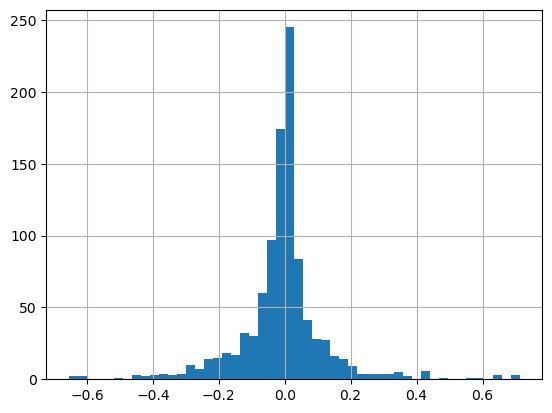

In [6]:
avg_infl.influence.hist(bins=50)

### Test GUID Highest Influence Training Point

In [79]:
max_infl = infl.groupby("test_guid").influence.max().reset_index()
max_infl["infl_rank"] = max_infl.influence.rank(ascending=False)
max_infl.sort_values("influence", ascending=False)

,test_guid,influence,infl_rank
528,528,34.377197,1.0
513,513,31.726635,2.0
579,579,30.966599,3.0
509,509,30.907408,4.0
544,544,28.714794,5.0
...,...,...,...
457,457,0.040811,868.0
15,15,0.032891,869.0
837,837,0.028385,870.0
443,443,0.019976,871.0


# Wrong Points

In [84]:
wrong_df[wrong_df.test_guid == 528]

,test_guid,logits,pred,label,loss,loss_rank
528,528,"[1.3232645, -1.6964343]",0,1,3.06736,5.0


In [94]:
data_utils.get_test_example(528).sentence.squeeze()

'it haunts , horrifies , startles and fascinates ; it is impossible to look away . '

In [87]:
infl[infl.test_guid == 528].sort_values("influence")

,train_guid,influence,test_guid
686,686,-28.414139,528
873,873,-23.315613,528
229,229,-15.682107,528
837,837,-15.358357,528
738,738,-14.990066,528
...,...,...,...
213,213,10.747519,528
526,526,11.047774,528
710,710,14.738692,528
3,3,16.359413,528


In [93]:
data_utils.get_train_example(873).sentence.squeeze()

'peels layers from this character that may well not have existed on paper . '

In [91]:
data_utils.get_train_example(686).sentence.squeeze()

'a meditation on faith and madness , frailty is blood-curdling stuff . '

In [95]:
data_utils.get_train_example(761).sentence.squeeze()

'the pianist like a surgeon mends a broken heart ; very meticulously but without any passion '

# Correctly Classified Points

## Test GUID Lowest Influence Training Point

In [78]:
min_infl = infl.groupby("test_guid").influence.min().reset_index()
min_infl["infl_rank"] = min_infl.influence.rank(ascending=False)
min_infl.sort_values("influence", ascending=False)

,test_guid,influence,infl_rank
334,334,-0.008348,1.0
837,837,-0.016448,2.0
443,443,-0.017967,3.0
15,15,-0.025015,4.0
613,613,-0.028230,5.0
...,...,...,...
513,513,-30.077068,868.0
832,832,-30.189003,869.0
867,867,-34.763771,870.0
869,869,-37.043121,871.0


## Test GIUD Highest Influence Training Point

In [81]:
max_infl[max_infl.test_guid.isin(high_conf)]

,test_guid,influence,infl_rank
15,15,0.032891,869.0
125,125,0.050493,865.0
303,303,0.079881,860.0
334,334,0.009979,872.0
443,443,0.019976,871.0
457,457,0.040811,868.0
613,613,0.042986,867.0
808,808,0.043101,866.0
825,825,0.055212,864.0
837,837,0.028385,870.0


In [82]:
min_infl[min_infl.test_guid.isin(high_conf)]

,test_guid,influence,infl_rank
15,15,-0.025015,4.0
125,125,-0.044609,10.0
303,303,-0.051041,12.0
334,334,-0.008348,1.0
443,443,-0.017967,3.0
457,457,-0.032868,7.0
613,613,-0.028230,5.0
808,808,-0.029786,6.0
825,825,-0.040168,8.0
837,837,-0.016448,2.0


## Influence of High Confidence Predictions

In [100]:
print(high_conf)

{guid: data_utils.get_test_example(guid).sentence.squeeze() for guid in high_conf}

[334, 443, 837, 303, 613, 457, 808, 15, 825, 125]


{334: "what really makes it special is that it pulls us into its world , gives us a hero whose suffering and triumphs we can share , surrounds him with interesting characters and sends us out of the theater feeling we 've shared a great adventure . ",
 443: 'good car chases , great fight scenes , and a distinctive blend of european , american and asian influences . ',
 837: 'will amuse and provoke adventurous adults in specialty venues . ',
 303: 'entertains by providing good , lively company . ',
 613: '... takes the beauty of baseball and melds it with a story that could touch anyone regardless of their familiarity with the sport ',
 457: "it inspires a continuing and deeply satisfying awareness of the best movies as monumental ` picture shows . ' ",
 808: 'enormously entertaining for moviegoers of any age . ',
 15: 'a gorgeous , high-spirited musical from india that exquisitely blends music , dance , song , and high drama . ',
 825: 'candid and comfortable ; a film that deftly balan

In [35]:
infl[infl.test_guid == 334].influence.describe()

count    1000.000000
mean        0.000008
std         0.001338
min        -0.008348
25%        -0.000363
50%        -0.000050
75%         0.000243
max         0.009979
Name: influence, dtype: float64

<Axes: >

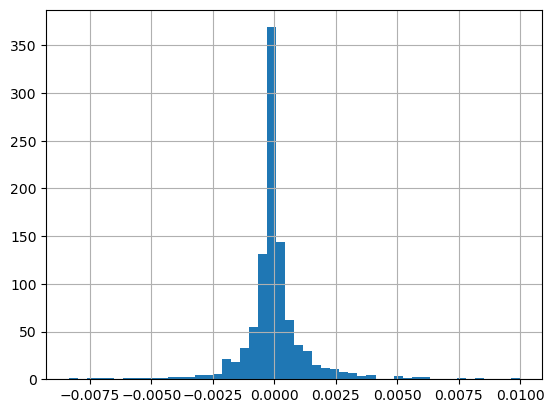

In [29]:
infl[infl.test_guid == 334].influence.hist(bins=50)

In [38]:
infl[infl.test_guid == 443].influence.describe()

count    1000.000000
mean        0.000055
std         0.003103
min        -0.017967
25%        -0.000859
50%        -0.000113
75%         0.000647
max         0.019976
Name: influence, dtype: float64

<Axes: >

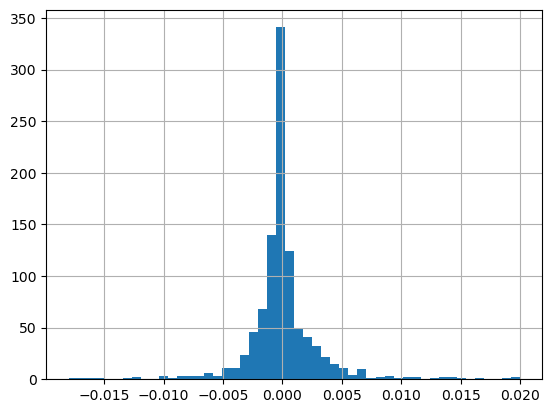

In [30]:
infl[infl.test_guid == 443].influence.hist(bins=50)

## Influence of Low Confidence Predictions

In [31]:
print(low_conf)
infl[infl.test_guid.isin(low_conf)]

[497, 870, 271, 695, 230, 42, 840, 733, 847, 425]


,train_guid,influence,test_guid
0,0,2.200142,42
1,1,0.430909,42
2,2,-0.039662,42
3,3,5.643315,42
4,4,0.187307,42
...,...,...,...
995,995,-0.938940,870
996,996,-0.430827,870
997,997,-0.021050,870
998,998,-1.582700,870


In [36]:
infl[infl.test_guid == 497].influence.describe()

count    1000.000000
mean       -0.071687
std         1.773631
min       -11.660325
25%        -0.439187
50%         0.017541
75%         0.371460
max        14.365940
Name: influence, dtype: float64

<Axes: >

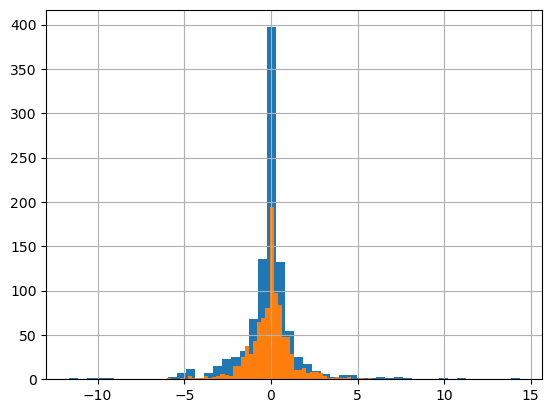

In [61]:
infl[infl.test_guid == 497].influence.hist(bins=50)
infl[infl.test_guid == 870].influence.hist(bins=50)

In [37]:
infl[infl.test_guid == 870].influence.describe()

count    1000.000000
mean       -0.048194
std         1.279529
min        -5.979610
25%        -0.607453
50%         0.027039
75%         0.488628
max         5.820967
Name: influence, dtype: float64

<Axes: >

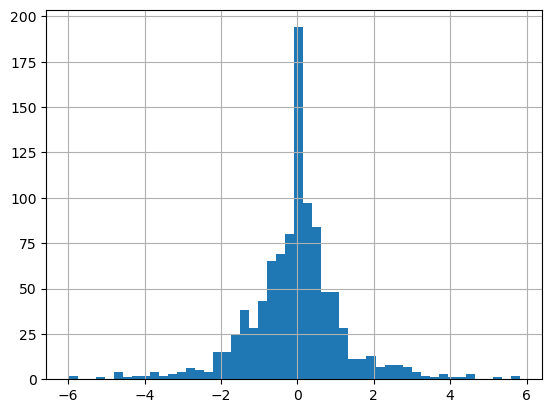

# Leave Out Fraction Sweep

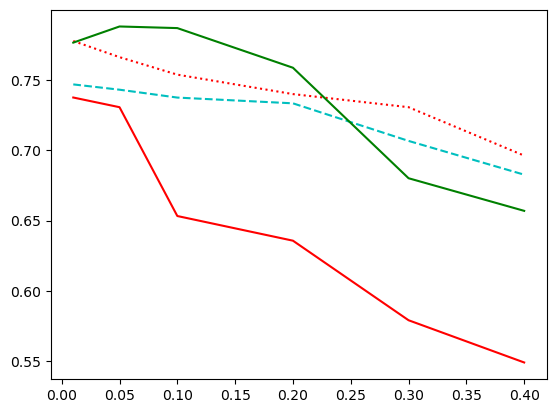

In [66]:
pdf = pd.read_csv("loo_sweep_results/influence_loo.csv")
srand = pd.read_csv("loo_sweep_results/random_loo.csv")

plt.plot(srand.reset_index().remove_pct, srand.accuracy, "r:")

zero = pdf[pdf.type == "zero"]
plt.plot(zero.remove_pct, zero.accuracy, "c--")

top = pdf[pdf.type == "top"]
plt.plot(top.remove_pct, top.accuracy, "g-")

bot = pdf[pdf.type == "bot"]
plt.plot(bot.remove_pct, bot.accuracy, "r-")

# Influence Plots

## No L2

In [2]:
config = utils.load_config(
    "loo_2k_l2/bert-classifier-base.yaml",
)

# Create datasets
train_dataset = create_train_sst2(
    num_samples=config["num_training_examples"],
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)

test_dataset = create_test_sst2(
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

og_model, fdf, test_loss, test_acc = train_utils.train_bert_model(
    train_dataset, test_dataset, config
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 9948.46it/s]


In [ ]:
TEST_GUID = 218

## With L2

In [2]:
model, config = BertClassifier.load_model(
    "model_params/bert-best.yaml"
)

test_dataset = create_test_sst2(
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

fdf, loss, acc = train_utils.evaluate_loss(model, test_dataloader)
print(config)
loss, acc

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 10377.90it/s]


{'batch_size': 32, 'bert_model_name': 'distilbert-base-uncased', 'classifier_drop_out': 0, 'classifier_hidden_size': 0, 'classifier_init_state_path': 'model_params/bert-epoch9-reg0.001-10000.pt', 'classifier_type': 'single-fc', 'epochs': 9, 'learning_rate': 0.0002, 'max_sequence_length': 64, 'num_training_examples': 10000, 'optimizer_weight_decay': 0.001}


(0.39863892992381156, 83.14220183486239)

In [3]:
fdf.sort_values('loss', ascending=True)

,test_guid,logits,pred,label,loss
15,15,"[-3.270208, 3.1246793]",1,1,0.001669
334,334,"[-3.2596936, 3.022319]",1,1,0.001868
808,808,"[-3.1854749, 3.0920424]",1,1,0.001876
443,443,"[-3.1042066, 3.0558453]",1,1,0.002110
837,837,"[-3.0979948, 2.9360476]",1,1,0.002393
...,...,...,...,...,...
494,494,"[-1.5574929, 1.2966905]",1,0,2.910188
528,528,"[1.3089001, -1.6915847]",0,1,3.049049
544,544,"[-2.088636, 1.667077]",1,0,3.778827
218,218,"[-2.1095824, 1.6889799]",1,0,3.820718


### Compare LOO With Influence Estimate

In [13]:
TEST_GUID = 218

TRAIN_LENGTH = 10000
results_dir = Path("results_10k_reg001")

# -- Load LOO Results --
loo_dir = results_dir / "loo" / f"test-guid-{TEST_GUID}"
loo_dfs = []
for train_guid in range(TRAIN_LENGTH):
    loss_path = loo_dir / f"run_{train_guid}" / "test_loss.csv"
    if os.path.exists(loss_path):
        try:
            df = pd.read_csv(loss_path)
        except:
            import pdb; pdb.set_trace()
        loo_dfs.append(df)
loo_results = pd.concat(loo_dfs)


# -- Load Influence Results --
infl_dir = results_dir / "influence"
infl = pd.read_csv(infl_dir / f"influence-testguid-{TEST_GUID}.csv")
infl["infl_diff"] = (-100.0 / TRAIN_LENGTH) * infl["influence"]


m = pd.merge(
    loo_results,
    fdf[["test_guid", "loss"]],
    on="test_guid",
    suffixes=("_loo", "_base"),
    how="outer",
)
m["loo_diff"] = m["loss_loo"] - m["loss_base"]
m = m[m.test_guid == TEST_GUID]

# -- Join LOO results and Influence Results --
comp = pd.merge(
    m,
    infl[["train_guid", "test_guid", "infl_diff"]],
    left_on=["test_guid", "loo_guid"],
    right_on=["test_guid", "train_guid"],
)
comp = comp.sort_values('infl_diff', ascending=True)
comp['infl_rank'] = comp.infl_diff.rank()

comp

,test_guid,logits,pred,label,loss_loo,loo_guid,loss_base,loo_diff,train_guid,infl_diff,infl_rank
6,218,[-2.1968067 1.7761151],1,0,3.991565,7274,3.820718,0.170847,7274,0.170382,1.0
1,218,[-2.1688771 1.7483537],1,0,3.936932,1669,3.820718,0.116214,1669,0.174762,2.0
8,218,[-2.0756178 1.6550142],1,0,3.754327,8691,3.820718,-0.066391,8691,0.175873,3.0
2,218,[-2.1857934 1.7647555],1,0,3.969610,2145,3.820718,0.148892,2145,0.185699,4.0
4,218,[-2.1638463 1.7432748],1,0,3.927020,6887,3.820718,0.106302,6887,0.193965,5.0
3,218,[-2.2003636 1.779828 ],1,0,3.998701,6668,3.820718,0.177983,6668,0.196687,6.0
7,218,[-2.035896 1.6153923],1,0,3.676915,8030,3.820718,-0.143803,8030,0.199606,7.0
5,218,[-2.268419 1.8476428],1,0,4.132239,7127,3.820718,0.311521,7127,0.199681,8.0
0,218,[-2.1686428 1.7482265],1,0,3.936577,761,3.820718,0.115859,761,0.214676,9.0


In [14]:
comp[['loo_diff', 'infl_diff']].corr()

,loo_diff,infl_diff
loo_diff,1.000000,0.072715
infl_diff,0.072715,1.000000


<Axes: xlabel='loo_diff', ylabel='infl_diff'>

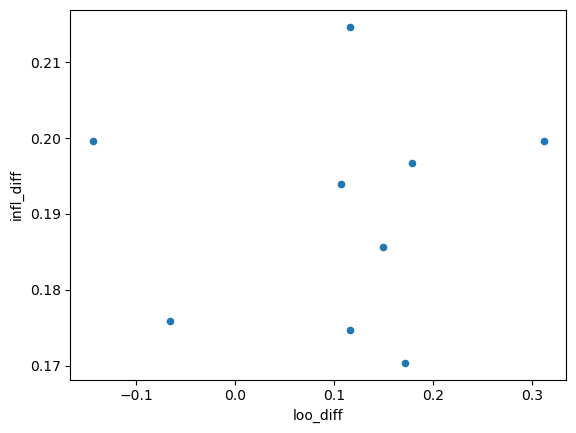

In [15]:
comp[['loo_diff', 'infl_diff']].plot.scatter('loo_diff', 'infl_diff')

<Axes: >

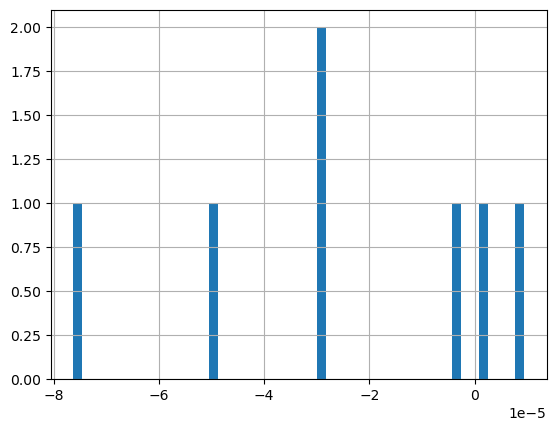

In [76]:
comp2['loo_diff'].hist(bins=50)

<Axes: >

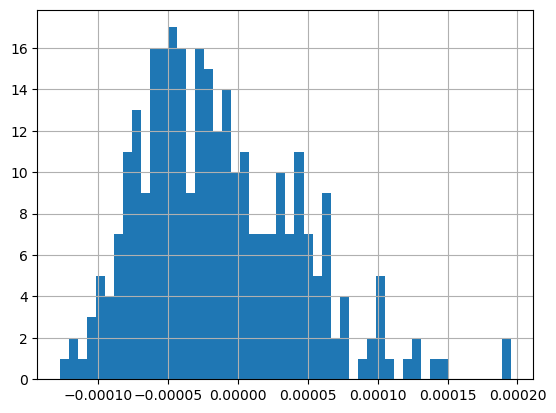

In [55]:
comp['loo_diff'].hist(bins=50)

<Axes: >

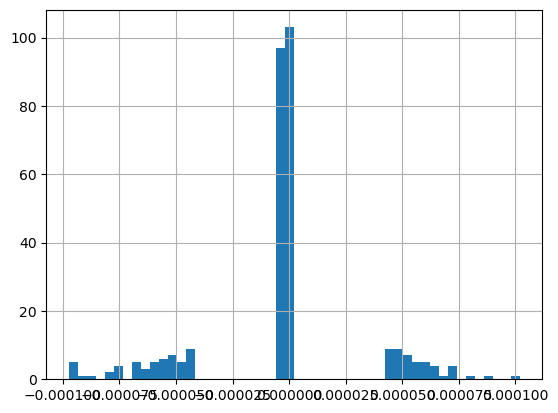

In [56]:
comp['infl_diff'].hist(bins=50)

In [43]:
infl2 = pd.read_csv('idf-218.csv')

<Axes: >

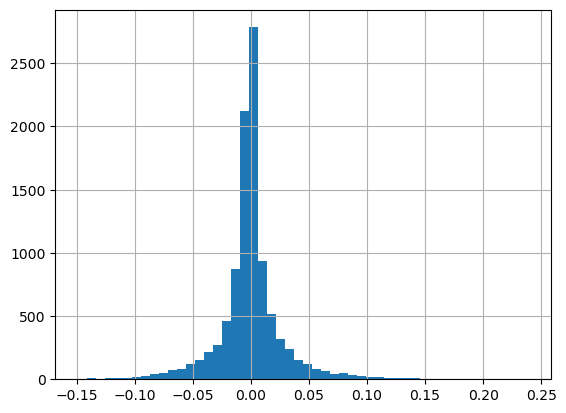

In [45]:
infl2['if'].hist(bins=50)

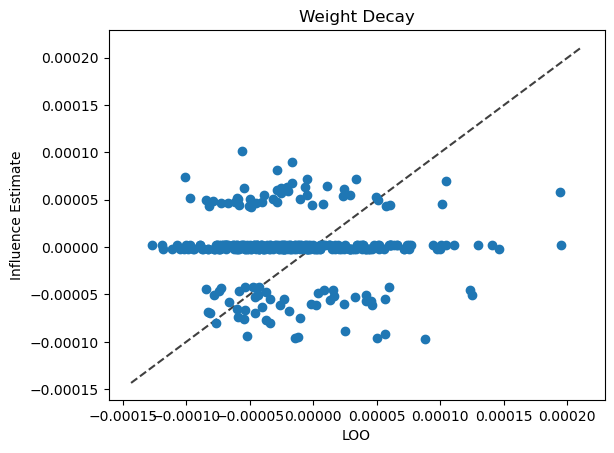

In [31]:
# comp[['loo_diff', 'infl_diff']].plot.scatter('loo_diff', 'infl_diff')

plt.title("Weight Decay")
plt.xlabel("LOO")
plt.ylabel("Influence Estimate")
plt.scatter(comp["loo_diff"], comp["infl_diff"])

# Plot a y=x line
ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, "k--", alpha=0.75, zorder=0)

## Weak L2

In [ ]:
model, config = BertClassifier.load_model(
    "results_10k_l2/bert-classifier-epoch5-10000-l2.yaml",
)

test_dataset = create_test_sst2(
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

fdf, loss, acc = train_utils.evaluate_loss(model, test_dataloader)
loss, acc

### Compare LOO with Influence Estimate

In [49]:
TEST_GUID = 218

TRAIN_LENGTH = 10000

# -- Load LOO Results --
loo_dir = f"results_10k_l2/loo/test-guid-{TEST_GUID}"
loo_dfs = []
for train_guid in range(TRAIN_LENGTH):
    loss_path = f"{loo_dir}/run_{train_guid}/test_loss.csv"
    if os.path.exists(loss_path):
        df = pd.read_csv(loss_path)
        loo_dfs.append(df)
loo_results = pd.concat(loo_dfs)


# -- Load Influence Results --
infl_dir = Path("results_10k_l2/influence/")
infl = pd.read_csv(infl_dir / f"influence-testguid-{TEST_GUID}.csv")
infl["infl_diff"] = (-100 / TRAIN_LENGTH) * infl["influence"]

# -- Join LOO results and Influence Results --
m = pd.merge(
    loo_results,
    fdf[["test_guid", "loss"]],
    on="test_guid",
    suffixes=("_loo", "_base"),
    how="outer",
)
m["loo_diff"] = m["loss_loo"] - m["loss_base"]
m = m[m.test_guid == TEST_GUID]

In [43]:
comp = pd.merge(
    m,
    infl[["train_guid", "test_guid", "infl_diff"]],
    left_on=["test_guid", "loo_guid"],
    right_on=["test_guid", "train_guid"],
)
comp

,test_guid,logits,pred,label,loss_loo,loo_guid,loss_base,loo_diff,train_guid,infl_diff
0,218,[-2.5173392 2.0890234],1,0,4.616301,761,4.406052,0.210249,761,0.181955
1,218,[-2.6340039 2.2082164],1,0,4.850079,843,4.406052,0.444027,843,0.190709
2,218,[-2.427691 2.00342 ],1,0,4.442942,910,4.406052,0.036890,910,-0.176765
3,218,[-2.4336889 2.0065231],1,0,4.451937,1669,4.406052,0.045885,1669,0.233304
4,218,[-2.565263 2.136173],1,0,4.710477,1909,4.406052,0.304425,1909,0.207187
5,218,[-2.38055 1.953742],1,0,4.347318,2426,4.406052,-0.058734,2426,0.185150
6,218,[-2.4642322 2.0378613],1,0,4.513118,2641,4.406052,0.107066,2641,0.174075
7,218,[-2.3215435 1.8914421],1,0,4.227679,2881,4.406052,-0.178373,2881,0.181441
8,218,[-2.414172 1.9868482],1,0,4.413210,2990,4.406052,0.007158,2990,0.180553
9,218,[-2.3838336 1.9557871],1,0,4.352578,3074,4.406052,-0.053474,3074,0.186611


In [ ]:
comp[['loo_diff', 'infl_diff']].corr()

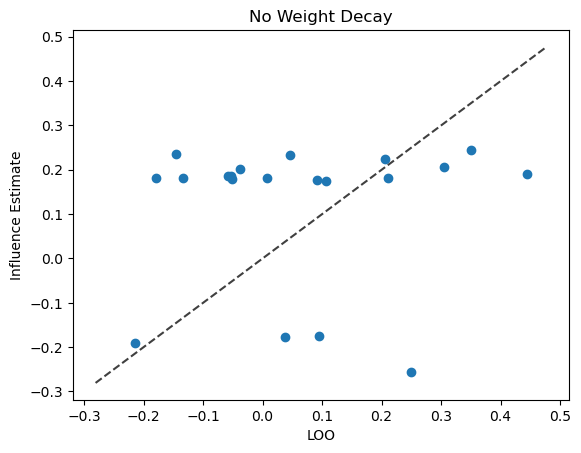

In [64]:
# comp[['loo_diff', 'infl_diff']].plot.scatter('loo_diff', 'infl_diff')

plt.title("No Weight Decay")
plt.xlabel("LOO")
plt.ylabel("Influence Estimate")
plt.scatter(comp["loo_diff"], comp["infl_diff"])

# Plot a y=x line
ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, "k--", alpha=0.75, zorder=0)

,train_guid,influence,test_guid,infl_diff
761,761,-18.195465,218,0.909773


### Influence Distributon of High Confidence Test Points

### Influence Distribution of Low Confidence Test Points